In [ ]:
%pip install -Uq lark

https://datawhalechina.github.io/llm-cookbook/#/C4/5.%20%E6%A3%80%E7%B4%A2%20Retrieval

检索是指根据用户的问题去向量数据库中搜索与问题相关的文档内容

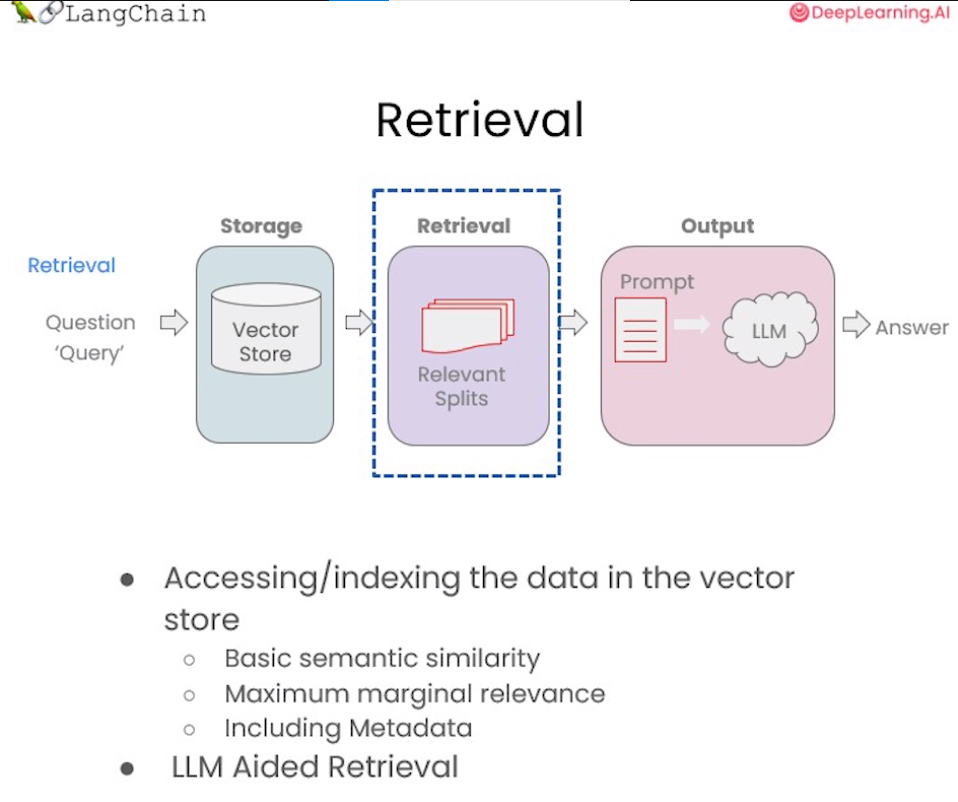


使用基本的相似性搜索大概能解决你80%的相关检索工作，但对于那些相似性搜索失败的边缘情况该如何解决呢？
这一章节我们将介绍几种检索方法，以及解决检索边缘情况的技巧

## 向量数据库检索

访问向量数据库会使用到如下几种技术：

* 基本语义相似度(Basic semantic similarity)
* 最大边际相关性(Maximum marginal relevance，MMR)
* 过滤元数据
* LLM辅助检索

### 1. 相似性检索

加载向量数据库(VectorDB)：

In [3]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

persist_directory_chinese = 'docs/'

embedding = OpenAIEmbeddings()

vectordb_chinese = Chroma(
    persist_directory=persist_directory_chinese,
    embedding_function=embedding
)

print(vectordb_chinese._collection.count())


18


下面我们来实现一下语义的相似度搜索，我们把三句话存入向量数据库Chroma中，然后我们提出问题让向量数据库根据问题来搜索相关答案。

创建子数据库

In [4]:
texts_chinese = [
    """毒鹅膏菌（Amanita phalloides）具有大型且引人注目的地上（epigeous）子实体（basidiocarp）""",
    """一种具有大型子实体的蘑菇是毒鹅膏菌（Amanita phalloides）。某些品种全白。""",
    """A. phalloides，又名死亡帽，是已知所有蘑菇中最有毒的一种。""",
]

smalldb_chinese = Chroma.from_texts(texts_chinese, embedding=embedding)

对提出的问题进行相似性搜索，设置 k=2 ，只返回两个最相关的文档。

In [4]:
question_chinese = "告诉我关于具有大型子实体的全白色蘑菇的信息"

smalldb_chinese.similarity_search(question_chinese, k=2)

[Document(page_content='一种具有大型子实体的蘑菇是毒鹅膏菌（Amanita phalloides）。某些品种全白。'),
 Document(page_content='毒鹅膏菌（Amanita phalloides）具有大型且引人注目的地上（epigeous）子实体（basidiocarp）')]

存在一些问题，因为第一句和第二句的含义非常接近，他们都是描述“鹅膏菌”及其“子实体”的，所以假如只返回其中的一句就足以满足要求了，如果返回两句含义非常接近的文本感觉是一种资源的浪费。

### 2. 解决多样性：最大边际相关性(MMR)

最大边际相关模型 (MMR，Maximal Marginal Relevance) 是实现多样性检索的常用算法。

MMR 的基本思想是同时考量查询与文档的相关度，以及文档之间的相似度。

具体来说，它计算每个候选文档与查询的相关度，并减去与已经选入结果集的文档的相似度。这样更不相似的文档会有更高的得分。

使用MMR 算法

In [5]:
smalldb_chinese.max_marginal_relevance_search(question_chinese,k=2, fetch_k=3)


[Document(page_content='一种具有大型子实体的蘑菇是毒鹅膏菌（Amanita phalloides）。某些品种全白。'),
 Document(page_content='A. phalloides，又名死亡帽，是已知所有蘑菇中最有毒的一种。')]

max_marginal_relevance_search（最大边际相关搜索） 返回了第二和第三句的文本，尽管第三句与我们的问题的相关性不太高，但是这样的结果其实应该是更加的合理，因为第一句和第二句文本本来就有着相似的含义，所以只需要返回其中的一句就可以了，另外再返回一个与问题相关性弱一点的答案(第三句文本)，这样似乎增强了答案的多样性，相信用户也会更加偏爱。

In [6]:
question_chinese = "Matplotlib是什么？"

docs_mmr_chinese = vectordb_chinese.max_marginal_relevance_search(question_chinese,k=3)


Number of requested results 20 is greater than number of elements in index 18, updating n_results = 18


### 3. 解决特殊性：使用元数据